In [85]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import keras

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))

from sklearn.metrics import mean_squared_error

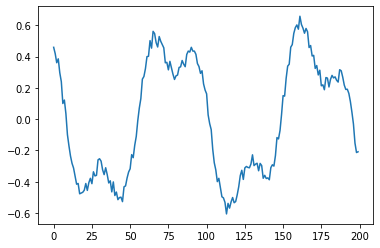

In [86]:
# generate data
# generates many time series
np.random.seed(42)
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

# just one timeseries
timeseries = generate_time_series(1, 200).ravel()
plt.plot(timeseries)
plt.show()

In [87]:
def forecast_tool(series, 
                  steps_back = 5,
                  steps_fore = 5,
                  train_share = .7,
                  scaling = False,
                  epochs = 50,
                  plot_output = False
                 ):
    """
    input is a series,
    output is a LSTM fitted series with a forecast
    """
    
    # preprocessing
    # 1. generate an input which considers steps_back predecessors
    def feat_pre(sequence, n_timestamp):
        """ generates features from multiple predecessor"""
        X = []
        for i in range(len(sequence)):
            end_ix = i + n_timestamp
            if end_ix > len(sequence):
                break
            # i to end_ix as input
            seq_x = sequence[i:end_ix]
            X.append(seq_x)
        return np.array(X)
    
    X = feat_pre(timeseries, steps_back)[:-1]
    y = timeseries[steps_back:]
    
    # 2. train/test split
    n_train = int(train_share * X.shape[0])
    X_train, y_train = X[:n_train], y[:n_train].reshape(-1,1)
    X_test, y_test = X[n_train:], y[n_train:]
    
    # 3. scale if scaling == True
    if scaling:
        X = sc.fit_transform(X)
        y = sc.fit_transform(y.reshape(-1, 1))
        X_train = sc.fit_transform(X_train)
        y_train = sc.fit_transform(y_train.reshape(-1, 1))
        X_test = sc.fit_transform(X_test)
        y_test = sc.fit_transform(y_test.reshape(-1, 1))
        
    # reshape for keras input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    X = X.reshape(X.shape[0], X.shape[1], 1) 
    
    # model: stacked LSTM
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(keras.layers.LSTM(50, activation='relu'))
    model.add(keras.layers.Dense(1))
        
    # fitting the model to the train data
    model.compile(loss ="mse", optimizer="adam")
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0)
    
    # compile again for the entire timeseries for forecasting
    # model: stacked LSTM
    # could be better: fit the model again with the whole timeseries
    model_fore = keras.models.Sequential()
    model_fore.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_fore.add(keras.layers.LSTM(50, activation='relu'))
    model_fore.add(keras.layers.Dense(1))
    # fit the model
    model_fore.compile(loss ="mse", optimizer="adam")
    history_fore = model_fore.fit(X, y, epochs=epochs, verbose = 0)
    # fitting the model: only boost with test data
    ## model.compile(loss ="mse", optimizer="adam")
    ## history_fore = model.fit(X_test, y_test, epochs=epochs, verbose = 0)

    if plot_output:
        fig, axes = plt.subplots(1,2, figsize=(12,8))
        # plot train loss
        axes[0].plot(history.history["loss"])
        axes[0].set_title("Training loss: {:.2f}".format(history.history["loss"][-1]))    
        axes[0].grid()
        # plot forecast loss
        axes[1].plot(history_fore.history["loss"])
        axes[1].set_title("Forecast loss: {:.4f}".format(history_fore.history["loss"][-1]))
        axes[1].grid()
        plt.show()
    
    # predict
    y_pred = model.predict(X.reshape(X.shape[0],X.shape[1],1)).ravel()
    # todo: forecast 
    X_fore = X[-1]
    y_fore = []
    for i in range(steps_fore):
        y_new = model_fore.predict(X_fore.reshape(1, X_fore.shape[0],1))[0][0]
        y_fore.append(y_new)
        X_fore = np.append(X_fore[1:], y_new)
    y_fore = np.array(y_fore)
        
    # Todo: descaling
    if scaling:
        y_pred = sc.inverse_transform(y_pred.reshape(1, -1))
        y_fore = sc.inverse_transform(y_fore.reshape(1, -1))
    
    return np.array([np.nan] * steps_back + list(y_pred.ravel()) + list(y_fore.ravel()))


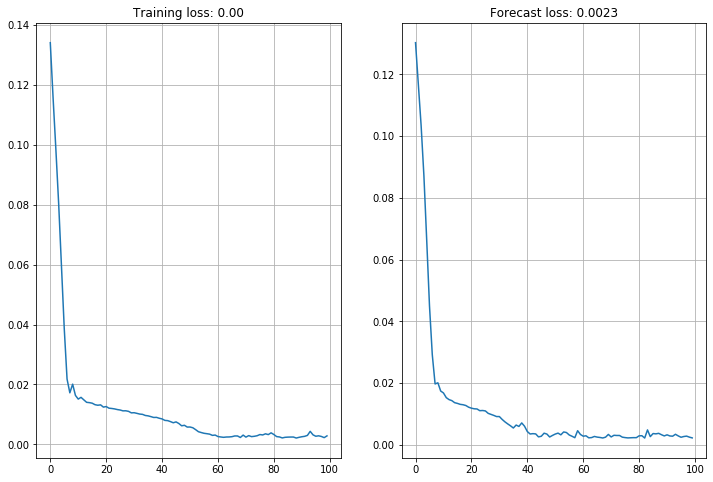

In [89]:
split_share = .7
steps_forecast = 20
steps_backward = 5
scal = False
eps = 100
model_series = forecast_tool(timeseries, steps_back = steps_backward,
                             train_share = split_share, steps_fore = 20, 
                             scaling = scal,
                             epochs = eps,
                             plot_output = True)

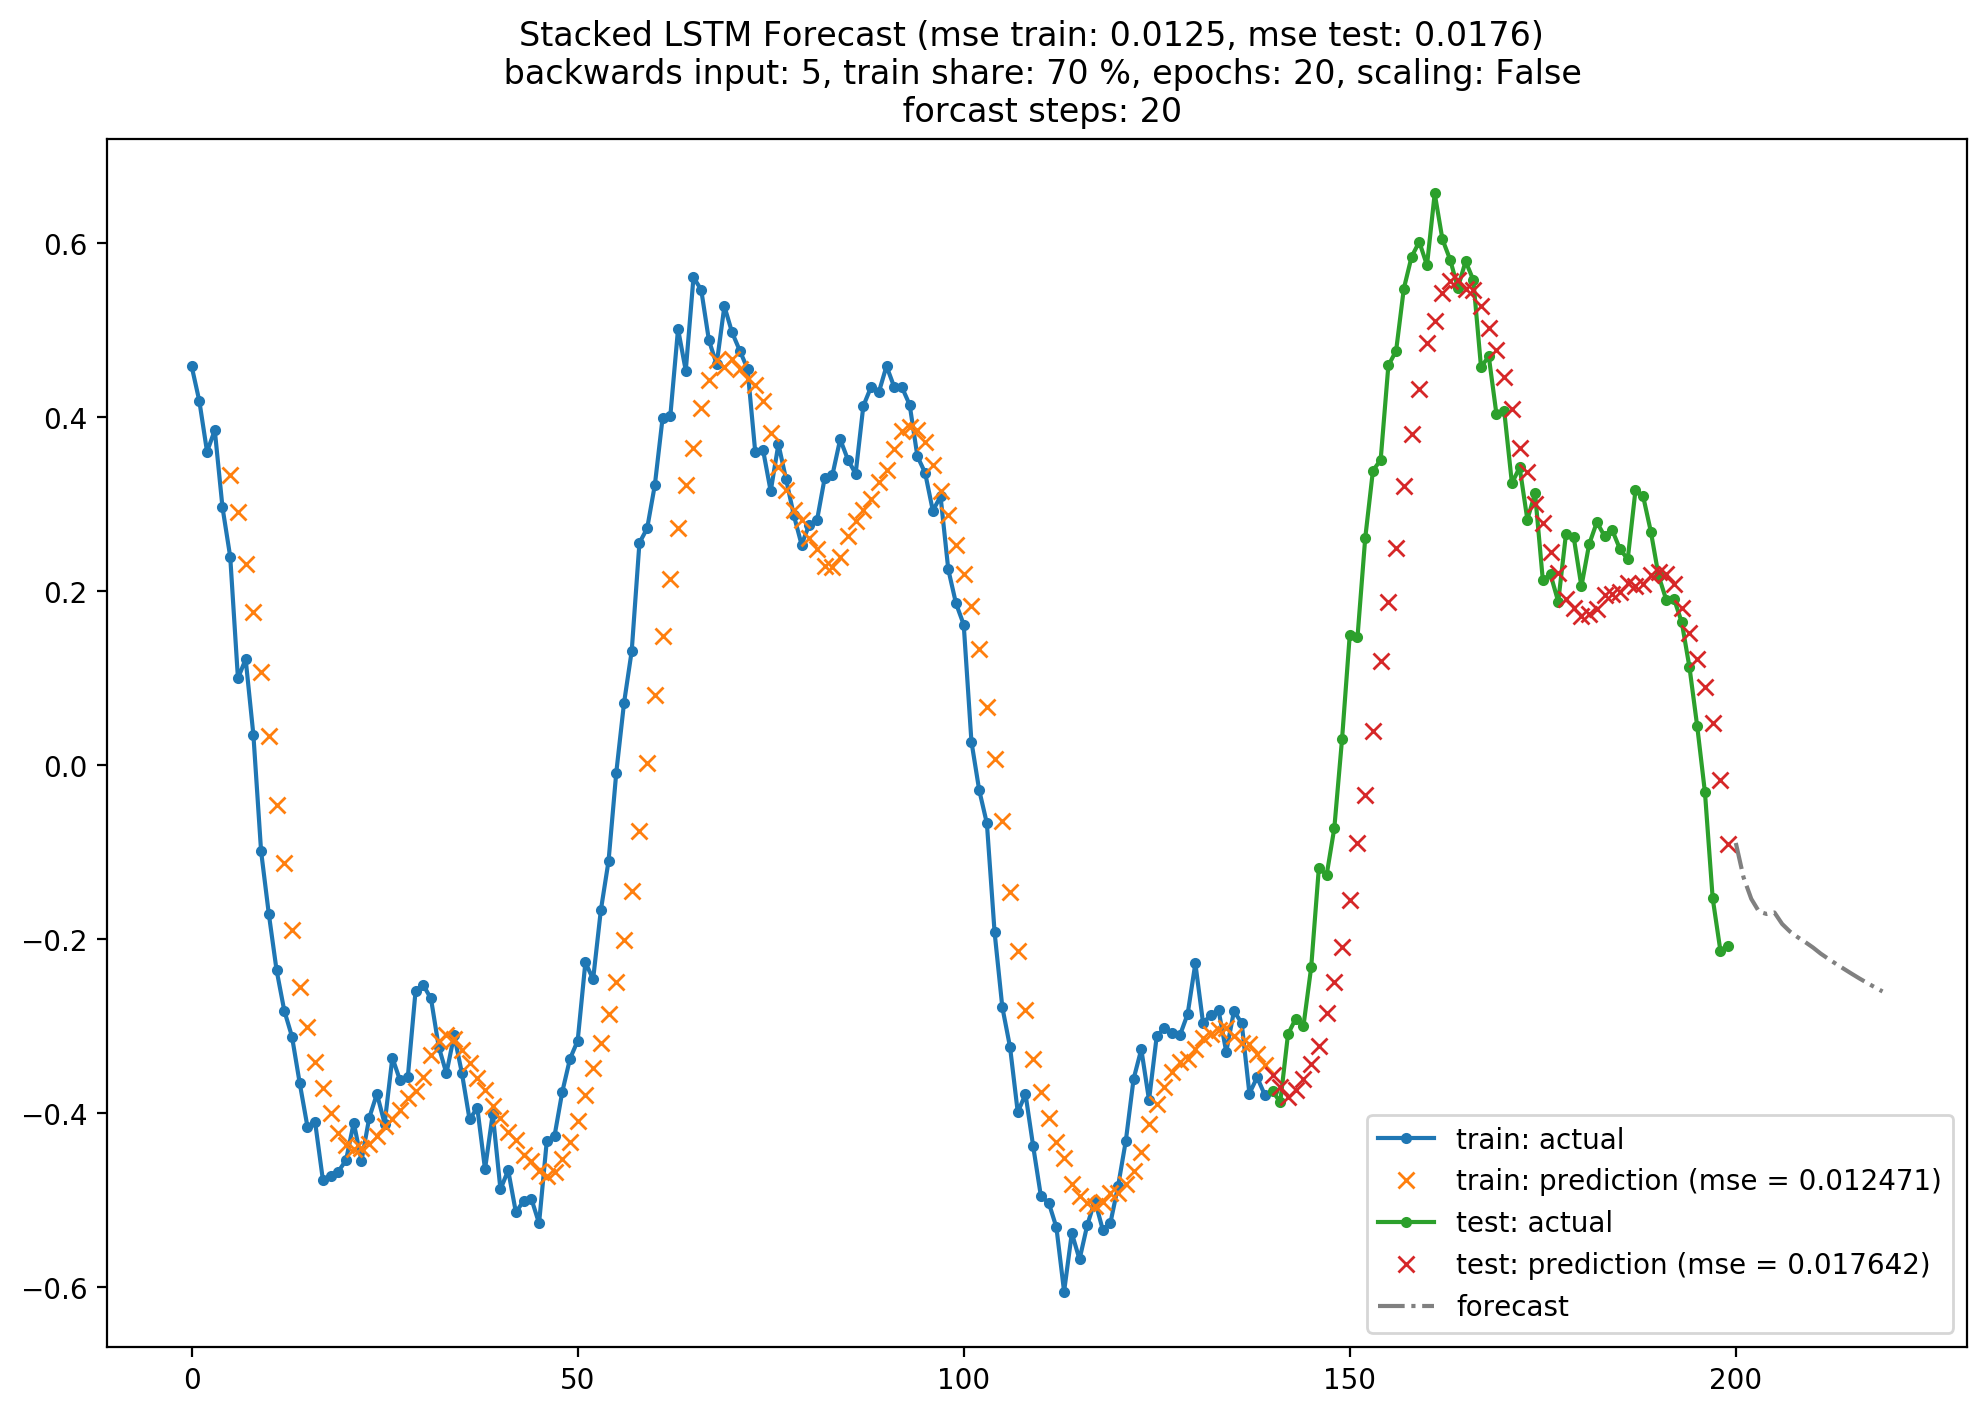

In [90]:
def plot_model(series,
               steps_forecast = 20,
               steps_backward = 5,
               split_share =.7,
               epochs = 100, 
               scaling=False):
    model_series = forecast_tool(series, steps_back = steps_backward,
                             train_share=split_share, steps_fore = steps_forecast, 
                             scaling=scaling,
                             epochs = epochs)
    
    n_split = int(split_share * len(series))
    fig, axes = plt.subplots(figsize=(12,8), dpi = 200)

    train_mse = mean_squared_error(series[steps_backward:n_split], model_series[steps_backward:n_split])
    test_mse = mean_squared_error(series[n_split:], model_series[n_split:len(series)])

    # train data
    plt.plot(series[:n_split],".-", label="train: actual")
    plt.plot(model_series[:n_split],"x", label="train: prediction (mse = {:4f})".format(train_mse))

    # test data
    plt.plot(range(n_split, len(series)),series[n_split:],".-", label="test: actual")
    plt.plot(range(n_split, len(series)),model_series[n_split:len(series)],"x", label="test: prediction (mse = {:4f})".format(test_mse))

    # forecast
    plt.plot(range(len(series), len(model_series)),
         model_series[len(series):],"-.", color='grey', label="forecast")
    plt.legend()
    plt.title("Stacked LSTM Forecast (mse train: {:.4f}, mse test: {:.4f}) \n backwards input: {}, train share: {:.0f} %, epochs: {}, scaling: {}\n forcast steps: {}".format(
        train_mse,test_mse, steps_backward, split_share * 100, epochs, scaling, steps_forecast
        )
    )
    plt.show()
    
plot_model(timeseries, epochs = 20)